In [143]:
import spacy
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

sns.set_palette(sns.color_palette("Spectral"))
sns.set_style("darkgrid")

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams["axes.labelsize"] = 15
pd.set_option('display.max_columns', 999)

In [ ]:

# read in RecipeNLG Dataset

df = pd.read_csv('RecipeNLG_Dataset.csv')

In [18]:
# takeout relevant columns
# convert from string to list literal

from ast import literal_eval

df_cols = df[["ingredients","NER","directions"]]

data = df_cols.sample(n = 10000, random_state = 42)

data["ingredients"] = data["ingredients"].apply(literal_eval)  
data["directions"] = data["directions"].apply(literal_eval)
data["NER"] = data["NER"].apply(literal_eval)
data.reset_index(inplace=True, drop = True)


import spacy
nlp=spacy.load('en_core_web_sm')
from spacy.tokens import Doc
from spacy.training import Example

In [499]:
# Make ingredient list

ingredients_list = df["NER"]
ingredients_list = ingredients_list.apply(literal_eval)
ingredients_list = ingredients_list.explode()
ingredients_list.drop_duplicates(inplace=True)
ingredients_list.reset_index(inplace=True, drop = True)

ingredients_list = ingredients_list[ingredients_list.apply(type) == str]
ingredients_list = ingredients_list.apply(lambda ingredient: ingredient.lower())

word_length = ingredients_list.apply(lambda ingredient: len(ingredient.split()))



<AxesSubplot:title={'center':'Ingredient Word Count Distribution'}, xlabel='Word Count', ylabel='Count'>

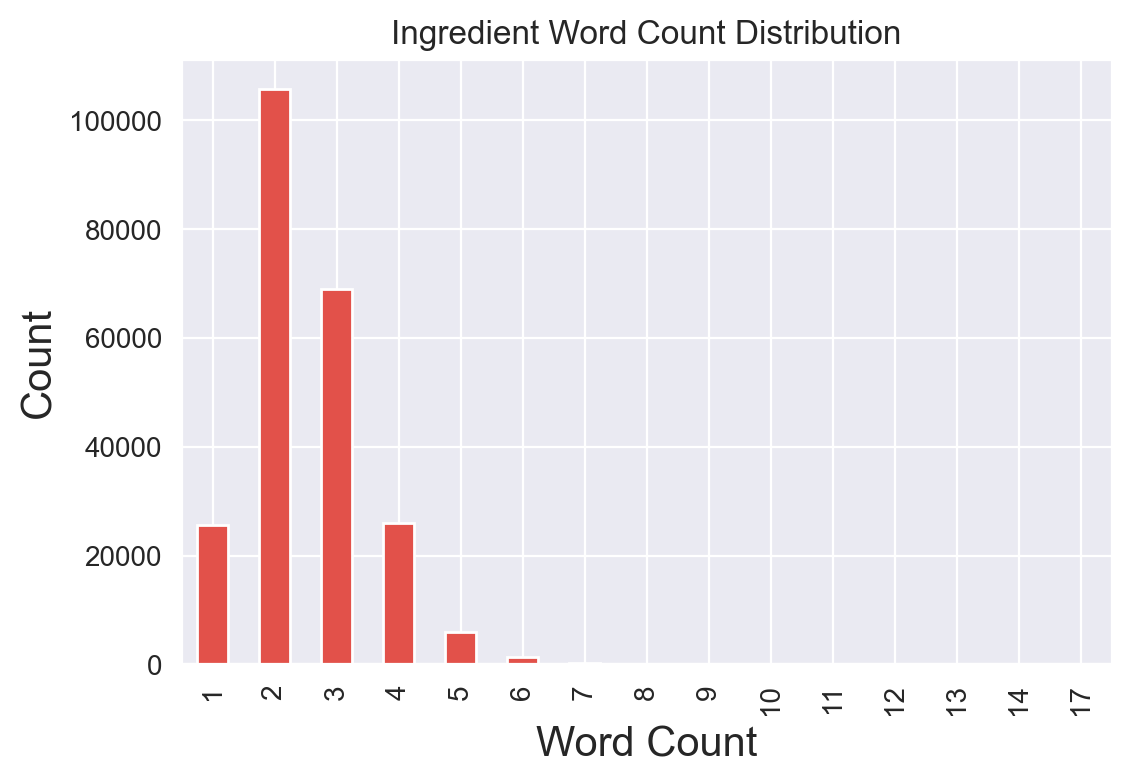

In [579]:
word_length.value_counts().sort_index().plot(kind='bar', title = "Ingredient Word Count Distribution", xlabel = "Word Count", ylabel = "Count")

In [506]:
# pretty goofy ingredients
print(ingredients_list[word_length == 17])

# get rid of all ingredients over 2 words long
ingredients_list = ingredients_list[word_length < 3]

# get rid of ingredients that are non-alpha numeric (excluding spaces) and more than 25 chars
def valid_ingredient(ingredient):
    bad_chars = []
    alnum_exclusions = {" "}

    if len(ingredient) > 25:
        return False

    for char in ingredient:
        if not char.isalnum():
            bad_chars.append(char)
    
    if len(bad_chars) != 0:
        if set(bad_chars) == alnum_exclusions:
            return True
        else:
            return False
    else:
        return True

ingredients_list = ingredients_list[ingredients_list.apply(valid_ingredient)]

114568    lime - added just prior to serving - stir well...
Name: NER, dtype: object


In [507]:
ingredients_list.describe()

count           115555
unique           91952
top       clove garlic
freq                 8
Name: NER, dtype: object

In [526]:
import random

prefixes = ["I have ", "I got ", "My fridge contains ", "I have in my fridge ", "I have in my kitchen ", "I have in my pantry ", "I have in my cupboard ", 
"I have in my cabinet ", "In this fridge, there is ", "I have in my fridge right now ", "My pantry contains ", "Hey, so I have ", "Hello, I have ", "Hey I got "]
seperator = [", ", " and ", " and also ", " ", " & ", " plus ", " in addition to ", " also ", " as well as "]
unit = ["some ", "a handful of ", "a block of ", "a cube of ", "a slice of ", "a stick of ", "one cup ", "a bag of ", "a gallon of "] + [""]*10


# initialize testing and training set (spacy Example object)
testing = pd.DataFrame(columns = ["sentence", "NER"])
training = pd.DataFrame(columns = ["sentence", "NER", "example"])

# initialize spacy nlp object
nlp = spacy.load("en_core_web_sm")
ner = nlp.get_pipe("ner")
ner.add_label("FOOD")

# to catch bad NERs
import warnings
warnings.filterwarnings("error")


def make_sentence(length = random.randint(5,15), testing = True):
    sentence = ""

    NER_list = []
    NER_label = "FOOD"
    NER_coords = []

    prefix = random.choice(prefixes)
    sentence += prefix

    curr_index = len(prefix)

    for i in range(length):
        
        seperator_choice = random.choice(seperator)
        unit_choice = random.choice(unit)
        ingredient = ingredients_list.sample(1).iloc[0]

        if not testing:
            NER_coords.append((curr_index, curr_index + len(ingredient), NER_label))
            curr_index += len(ingredient) + len(seperator_choice) + len(unit_choice)

        sentence += ingredient
        sentence += seperator_choice
        sentence += unit_choice
        
        NER_list.append(ingredient)

    sentence = sentence[:-(len(seperator_choice)+len(unit_choice))]
    if testing:
        return {"sentence":sentence, "NER":NER_list}
    else:
        doc = nlp.make_doc(sentence)
        try:
            temp = {"sentence":sentence, "NER":NER_list, "example":Example.from_dict(doc, {"entities":NER_coords})}
        except:
            print(f"{sentence} cannot be aligned")
            return None
        return temp


# stop catching warnings as errors
warnings.filterwarnings("default")

In [527]:
# Populate Training and Testing Set

training_set_len = 1000
testing_set_len = 300


for i in range(testing_set_len):
    testing = testing.append(make_sentence(), ignore_index = True)

testing.to_csv("validation.csv", index = False)

for i in range(training_set_len):
    training = training.append(make_sentence(testing = False), ignore_index = True)

training.to_csv("training.csv", index = False)

In [528]:
# define train, validation, and testing sets
TRAIN_DATA = training["example"]
validation = pd.read_csv("validation.csv")
test = pd.read_csv("testing.csv")

# convert from string to list literal
validation["NER"] = validation["NER"].apply(literal_eval)
test["NER"] = test["NER"].apply(literal_eval)


# loss statistics

# percent of ingredients that are in the prediction
def undiscovered_rate(row):
    correct = 0
    incorrect = 0
    for i in row["NER"]:
        if i in row["prediction"]:
            correct += 1
        else:
            incorrect += 1
    return incorrect / (correct + incorrect)

# percent of predicted ingredients that are invalid
def false_positive_rate(row):
    correct = 0
    incorrect = 0
    for i in row["prediction"]:
        if i in row["NER"]:
            correct += 1
        else:
            incorrect += 1
    return incorrect / (correct + incorrect)



In [531]:
# training
nlp = spacy.load("en_core_web_sm")
ner = nlp.get_pipe("ner")
ner.add_label("FOOD")

optimizer = nlp.create_optimizer()
optimizer.learn_rate = 0.005

# Disable pipeline components you dont need to change
pipe_exceptions = ["ner", "trf_wordpiecer", "trf_tok2vec"]
unaffected_pipes = [pipe for pipe in nlp.pipe_names if pipe not in pipe_exceptions]

# Import requirements
import random
from spacy.util import minibatch, compounding
from pathlib import Path

# load checkpoint model
# nlp = spacy.load("model/ingredients_model100")

# where to store epoch performance
from collections import deque

training_loss = deque()

validation_loss_accuracy = deque()
validation_loss_fpr = deque()
validation_loss_ur = deque()

testing_loss_accuracy = deque()
testing_loss_fpr = deque()
testing_loss_ur = deque()


model_name = "model_no_dash_ingreds"

# TRAINING THE MODEL
with nlp.disable_pipes(*unaffected_pipes):

  # Training for 20 iterations
  for iteration in range(1,10):

    # shuufling examples  before every iteration
    random.shuffle(TRAIN_DATA)
    losses = {}
    # batch up the examples using spaCy's minibatch
    batches = minibatch(TRAIN_DATA, size=compounding(4, 32, 1.05))    

    for batch in batches:
      nlp.update(batch, losses=losses, drop=0.5, sgd = optimizer)
    
    print(f"Epoch {iteration} Training Loss: ", losses)
    training_loss.append(losses['ner'])

    # get validation predictions and calculate loss
    validation["prediction"] = validation["sentence"].apply(lambda x: list(map(str,list(nlp(x).ents))))
    validation["share ingredients undiscovered"] = validation.apply(undiscovered_rate, axis = 1)
    validation["percent ingredients wrong"] = validation.apply(false_positive_rate, axis = 1)
    validation["correct"] = validation.apply(lambda x: x["NER"] == x["prediction"], axis = 1)

    test["prediction"] = test["sentence"].apply(lambda x: list(map(str,list(nlp(x).ents))))
    test["share ingredients undiscovered"] = test.apply(undiscovered_rate, axis = 1)
    test["percent ingredients wrong"] = test.apply(false_positive_rate, axis = 1)
    test["correct"] = test.apply(lambda x: x["NER"] == x["prediction"], axis = 1)

    validation_loss_accuracy.append(1 - validation["correct"].mean())
    validation_loss_fpr.append(validation["percent ingredients wrong"].mean())
    validation_loss_ur.append(validation["share ingredients undiscovered"].mean())
    print(f"Validation Losses (Innaccuracy, False Positive Rate, Undiscovered Rate): ({validation_loss_accuracy[-1]:.2f},{validation_loss_fpr[-1]:.2f}, {validation_loss_ur[-1]:.2f})") 


    testing_loss_accuracy.append(1 - test["correct"].mean())
    testing_loss_fpr.append(test["percent ingredients wrong"].mean())
    testing_loss_ur.append(test["share ingredients undiscovered"].mean())
    print(f"Testing Losses (Innaccuracy, False Positive Rate, Undiscovered Rate): ({testing_loss_accuracy[-1]:.2f},{testing_loss_fpr[-1]:.2f}, {testing_loss_ur[-1]:.2f})") 

    # every epoch, save the model
    nlp.to_disk(f'{model_name}/ingredients_model{iteration}')

Epoch 1 Training Loss:  {'ner': 4403.56887071377}
Validation Losses (Innaccuracy, False Positive Rate, Undiscovered Rate): (0.19,0.01, 0.02)
Testing Losses (Innaccuracy, False Positive Rate, Undiscovered Rate): (0.50,0.15, 0.11)
Epoch 2 Training Loss:  {'ner': 620.9216327526549}
Validation Losses (Innaccuracy, False Positive Rate, Undiscovered Rate): (0.20,0.01, 0.02)
Testing Losses (Innaccuracy, False Positive Rate, Undiscovered Rate): (0.60,0.16, 0.13)
Epoch 3 Training Loss:  {'ner': 434.16471774336713}
Validation Losses (Innaccuracy, False Positive Rate, Undiscovered Rate): (0.13,0.01, 0.02)
Testing Losses (Innaccuracy, False Positive Rate, Undiscovered Rate): (0.60,0.19, 0.12)
Epoch 4 Training Loss:  {'ner': 339.9730979485139}
Validation Losses (Innaccuracy, False Positive Rate, Undiscovered Rate): (0.12,0.01, 0.02)
Testing Losses (Innaccuracy, False Positive Rate, Undiscovered Rate): (0.60,0.19, 0.12)
Epoch 5 Training Loss:  {'ner': 242.21323348497015}
Validation Losses (Innaccura

In [532]:
# save model statistics
pd.DataFrame({"training_loss":training_loss, "validation_loss_accuracy":validation_loss_accuracy, "validation_loss_fpr":validation_loss_fpr, "validation_loss_ur":validation_loss_ur, "testing_loss_accuracy":testing_loss_accuracy, "testing_loss_fpr":testing_loss_fpr, "testing_loss_ur":testing_loss_ur}).to_csv(f"{model_name}/model_statistics.csv", index = False)

In [539]:
# test model
nlp = spacy.load("model_no_dash_ingreds/ingredients_model9")
nlp("I have spring mix, chicken breast, chili, and hamburger meat").ents

(spring mix, chicken breast, chili, hamburger meat)

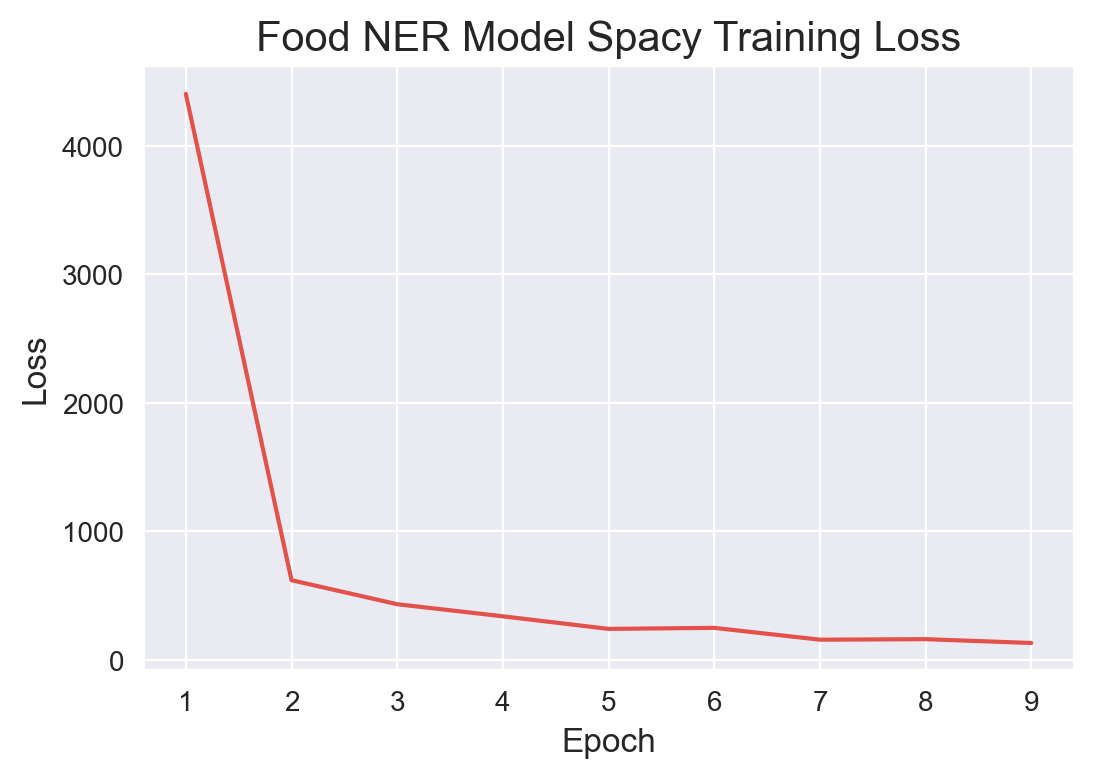

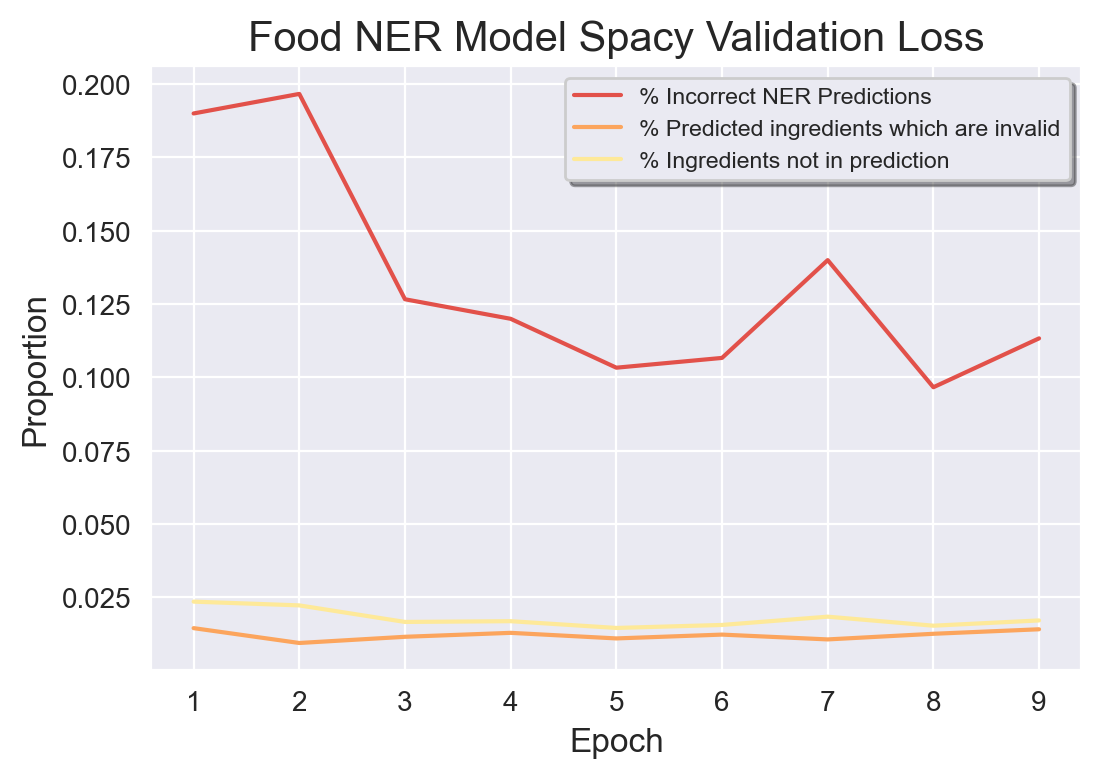

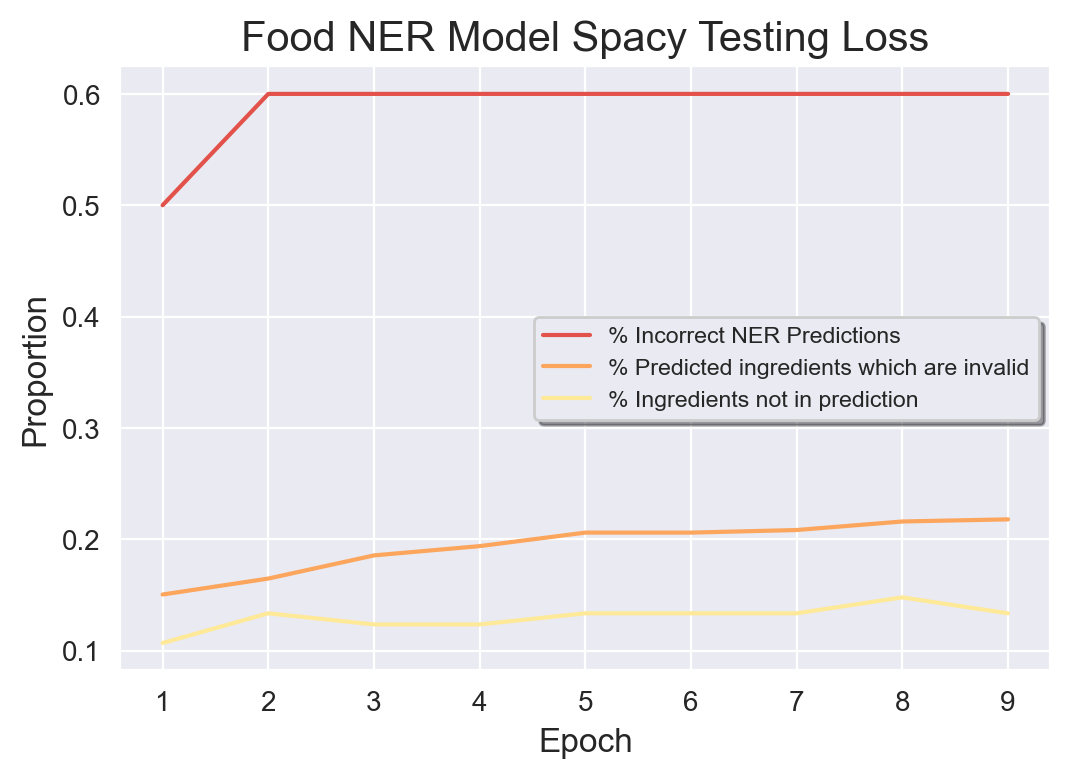

In [577]:
# display model statistics

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(1,10), training_loss)
ax.set_ylabel("Loss", fontsize = 12)
ax.set_xlabel("Epoch", fontsize = 12)
ax.set_title("Food NER Model Spacy Training Loss", fontsize = 15)

fig.savefig("training_loss.png")



fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(1,10), validation_loss_accuracy, label = "% Incorrect NER Predictions")
ax.plot(range(1,10), validation_loss_fpr, label = "% Predicted ingredients which are invalid")
ax.plot(range(1,10), validation_loss_ur, label = "% Ingredients not in prediction")
ax.set_ylabel("Proportion", fontsize = 12)
ax.set_xlabel("Epoch", fontsize = 12)
ax.set_title("Food NER Model Spacy Validation Loss", fontsize = 15)
legend = ax.legend(loc='upper right', shadow=True, fontsize='small')
fig.savefig("validation_loss.png")

fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(range(1,10), testing_loss_accuracy, label = "% Incorrect NER Predictions")
ax.plot(range(1,10), testing_loss_fpr, label = "% Predicted ingredients which are invalid")
ax.plot(range(1,10), testing_loss_ur, label = "% Ingredients not in prediction")
ax.set_ylabel("Proportion", fontsize = 12)
ax.set_xlabel("Epoch", fontsize = 12)
ax.set_title("Food NER Model Spacy Testing Loss", fontsize = 15)
legend = ax.legend(loc='best', shadow=True, fontsize = "small")

fig.savefig("testing_loss.png")